### If We have the T,M,N of a cancer, We can easily find the stage of Tumor
### But can we find the stage with other datas?

Our tasks contain:
- 1- Cleaning data
- 2- Train a machine learning model to find the percise stage with T,M,N
- 3- Train a machine learning model to find the stage without T,M,N
- 4- diffrent technics to find the stage without T,N,M
- 5- Report accuracy and conclusion

We get our Oropharyngeal Cancer data from:<br>

https://wiki.cancerimagingarchive.net/download/attachments/70226325/RADCURE_TCIA_Clinical%20June%2013%202023.xlsx?api=v2<br>
https://wiki.cancerimagingarchive.net/pages/tinyurl.action?urlIdentifier=lZEvB

dataset was collected clinically for radiation therapy treatment planning

#### Importing useful packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import tree
from keras import layers, optimizers, losses, metrics, models
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

%matplotlib inline

#### Reading CSV Data

In [2]:
data = pd.read_excel('RADCURE_TCIA_Clinical June 13 2023.xlsx')
print(data.shape)
data.head()

(3346, 34)


,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Cause of Death,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,Other Cause,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,Other Cause,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaN,NaT,NaN,NaT,NaN,NaT,S (suspecious),2008-05-27,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0


### Brief description of the Data
- What is the ECoG PS score?
- The ECOG PS scale indicates increasing levels of disability:
    - 0 indicating fully active
    - 1 restricted in strenuous activity
    - 2 restricted in work activity but ambulatory and capable of self-care
    - 3 capable of limited self-care
    - 4 completely disabled
    - 5 dead

- Pay attention to unknown values
- Smoking PY is Smoking pocket year
- RT means radiation thrapy
- Last column is related to the collectors of data and their split into train test data -> will drop that

Since our aim is predicting the tumor stage, we don't need the data about the therapy methods and time of <br>Radiation Therapy start , the dosage  and technic; So we'll drop the columns related to treatment<br>
`['Tx Modality', 'Chemo? ', 'RT Start', 'Dose', 'Fx', 'RT Tech', 'Last FU', 'Length FU']`

## 1- Data Cleaning

In [3]:
# dropping patient_id & RADCURE-challenge column 
data.drop(columns=['patient_id', "RADCURE-challenge",'Tx Modality', 'Chemo? ', 'RT Start', 'Dose', 'Fx', 'RT Tech', 'Last FU', 'Length FU']
          , inplace=True)

# counting Nans in columns
data.isna().sum(axis=0)

Age                  0
Sex                  0
ECOG PS              1
Smoking PY           5
Smoking Status       0
Ds Site              0
Subsite            374
T                   12
N                   13
M                   14
Stage               27
Path                 0
HPV               1629
Status               0
Date of Death     2288
Cause of Death    2294
Local             2966
Date Local        2966
Regional          3157
Date Regional     3157
Distant           2933
Date Distant      2933
2nd Ca            2905
Date 2nd Ca       2907
dtype: int64

In [4]:
#print(data.columns)
#print()
#dropping columns with more than 1500 Nan values
a_lot_of_non_series = data.isna().sum(axis=0) > 1500

# getting index of headers with a_lot_of_nans as a list
will_drop = list(a_lot_of_non_series[a_lot_of_non_series].index)

#print(will_drop)    # We can check them

#dropping will_drop list
data.drop(columns=will_drop, inplace=True)

print(data.shape)
print('number of remaining nan values:', data.isna().sum(axis=0).sum())
data.head()


(3346, 13)
number of remaining nan values: 446


,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,M,Stage,Path,Status
0,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,M0,IVB,Squamous Cell Carcinoma,Dead
1,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,M0,I,Squamous Cell Carcinoma,Dead
2,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,M0,IVA,Squamous Cell Carcinoma,Alive
3,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,M0,IVA,Squamous Cell Carcinoma,Alive
4,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,M0,IVB,Squamous Cell Carcinoma,Alive


In [5]:
data

,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,M,Stage,Path,Status
0,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,M0,IVB,Squamous Cell Carcinoma,Dead
1,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,M0,I,Squamous Cell Carcinoma,Dead
2,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,M0,IVA,Squamous Cell Carcinoma,Alive
3,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,M0,IVA,Squamous Cell Carcinoma,Alive
4,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,M0,IVB,Squamous Cell Carcinoma,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,58.3,Male,ECOG 0,50,Ex-smoker,Oropharynx,Tonsil Pillar,T2,N0,M0,II,Squamous Cell Carcinoma,Dead
3342,52.4,Female,ECOG 0,30,Current,Oropharynx,Base of Tongue,T2,N2b,M0,IVA,Squamous Cell Carcinoma,Alive
3343,71.3,Male,ECOG 1,50,Ex-smoker,Oropharynx,Soft Palate,T2,N0,M0,II,Squamous Cell Carcinoma,Alive
3344,53.9,Female,ECOG 0,5,Current,Oropharynx,Tonsillar Fossa,T2,N2b,M0,IVA,Squamous Cell Carcinoma,Dead


In [6]:
data.isna().sum(axis=0).sum()

# If We drop the entire column of subsite(number of nans = 374, saw 2 cells above) we'll lose less data
# then We'll drop all columns with Nan values and will lose about 70 rows out of 3346

data.drop(columns=['Subsite'], inplace=True)    #actually it has 374 nans but we will drop this
data.dropna( inplace=True)
data.reset_index(drop=True, inplace=True)    #reseting indexes to remove the affect of dropping rows
print(data.shape)

(3314, 12)


In [7]:
# At last We drop the unknown

# You can see the number of rows with these values
# (data == 'Unknown').sum()   # in columns of `ECOG PS` , `Ds Site`
# (data == 'unknown').sum()   # in column of Smoking `Status, It has high potential to predict sth later XD
# (data == 'na').sum()        # in column of `Smoking PY`

Unknown = data[(data['ECOG PS'] == 'Unknown') | (data['Ds Site'] == 'Unknown')].index
unknown = data[data['Smoking Status'] == 'unknown'].index
na = data[data['Smoking PY'] == 'na'].index

union_indices = Unknown.union(unknown).union(na)    #union of indices shoud delete

print('original len is',len(data), '& union of deleting indices len is', len(union_indices))

# Dropping the indices from the dataframe
data.drop(index=union_indices, axis=0, inplace=True)

# Reseting the indices
data.reset_index(drop=True, inplace=True)

print(data.shape)
data.head()

original len is 3314 & union of deleting indices len is 223
(3091, 12)


,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,T,N,M,Stage,Path,Status
0,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,T4b,N2c,M0,IVB,Squamous Cell Carcinoma,Dead
1,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,T1b,N0,M0,I,Squamous Cell Carcinoma,Dead
2,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,T3,N2b,M0,IVA,Squamous Cell Carcinoma,Alive
3,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,T4b,N0,M0,IVB,Squamous Cell Carcinoma,Alive
4,72.3,Male,ECOG 0,55,Current,Larynx,T1a,N0,M0,I,Squamous Cell Carcinoma,Alive


##### At last we add an underline (_) to headers with space

In [8]:
data.columns = [header.strip().replace(" ", "_") for header in data.columns]
data.head()

,Age,Sex,ECOG_PS,Smoking_PY,Smoking_Status,Ds_Site,T,N,M,Stage,Path,Status
0,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,T4b,N2c,M0,IVB,Squamous Cell Carcinoma,Dead
1,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,T1b,N0,M0,I,Squamous Cell Carcinoma,Dead
2,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,T3,N2b,M0,IVA,Squamous Cell Carcinoma,Alive
3,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,T4b,N0,M0,IVB,Squamous Cell Carcinoma,Alive
4,72.3,Male,ECOG 0,55,Current,Larynx,T1a,N0,M0,I,Squamous Cell Carcinoma,Alive


Now our data doesn't have Nan values and the columns & rows with less information have been droped<br>
In this section We are going to create first model

## 2- Creating model with T, N, M


### 2-1 prediction Stage with T,N,M

In [9]:
data

,Age,Sex,ECOG_PS,Smoking_PY,Smoking_Status,Ds_Site,T,N,M,Stage,Path,Status
0,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,T4b,N2c,M0,IVB,Squamous Cell Carcinoma,Dead
1,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,T1b,N0,M0,I,Squamous Cell Carcinoma,Dead
2,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,T3,N2b,M0,IVA,Squamous Cell Carcinoma,Alive
3,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,T4b,N0,M0,IVB,Squamous Cell Carcinoma,Alive
4,72.3,Male,ECOG 0,55,Current,Larynx,T1a,N0,M0,I,Squamous Cell Carcinoma,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...
3086,58.3,Male,ECOG 0,50,Ex-smoker,Oropharynx,T2,N0,M0,II,Squamous Cell Carcinoma,Dead
3087,52.4,Female,ECOG 0,30,Current,Oropharynx,T2,N2b,M0,IVA,Squamous Cell Carcinoma,Alive
3088,71.3,Male,ECOG 1,50,Ex-smoker,Oropharynx,T2,N0,M0,II,Squamous Cell Carcinoma,Alive
3089,53.9,Female,ECOG 0,5,Current,Oropharynx,T2,N2b,M0,IVA,Squamous Cell Carcinoma,Dead


In [10]:
# Now we want to split data and implement one_hot_encoding to train and test data
TNM_model_X = data[['T','N','M']]
TNM_model_y = data[['Stage']]    # Pay attention some values are 0 (int); turn them to str(0)

# turning int(0) to str(0)
TNM_model_y.loc[TNM_model_y.Stage == 0] = str(0)   # This line is dirty
# TNM_model_y.replace(TNM_model_y.Stage == 0,str(0))

X = pd.get_dummies(TNM_model_X[['T','N','M']],prefix='', prefix_sep='', dtype=int)
y = pd.get_dummies(TNM_model_y, dtype=int) 

# Splitting the data to 60, 20, 20 --> train, validation, test
X_train, Xs, y_train, ys = train_test_split(X,y, test_size=0.4)
X_test, X_validation, y_test, y_validation = train_test_split(Xs,ys, test_size=0.5)

C:\Users\ToTo\AppData\Local\Temp\ipykernel_7340\2620410414.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TNM_model_y.loc[TNM_model_y.Stage == 0] = str(0)   # This line is dirty


#### We use 2 models: Decision tree & random forest
decision tree  has binary branches and can visualize the data but random forest has diffrent branches, it's <br>slower and most of times
has higher accuracy

### 2-2 Decision Tree

In [11]:
tree.DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [12]:
params = {'criterion': ['gini', 'entropy'],
 'max_depth': [ 10, 20, 30, 50, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5, 10],
 }

hp_values = list(params.values())    # hp stands for hyper parameters

# import itertools
# Get every combination of the hyperparameters
# for hp in itertools.product(*hp_values):
#     print(hp)

# Initialize best_param & accuracy
dt_best_param = None
dt_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = tree.DecisionTreeClassifier(criterion = hp[0],
                                            max_depth = hp[1],
                                            max_features = hp[2],
                                            min_samples_leaf = hp[3],
                                            min_samples_split = hp[4],
                                            random_state = 42
                                           )
    # Fit the model
    estimator.fit(X_train, y_train)
    accuracy = estimator.score(X_validation, y_validation)
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > dt_best_accuracy:
        dt_best_accuracy = estimator.score(X_test, y_test)
        dt_best_param = hp

Parameters used: ('gini', 10, 'sqrt', 1, 2)
Mean accuracy of the model: 0.8788368336025848

Parameters used: ('gini', 10, 'sqrt', 1, 5)
Mean accuracy of the model: 0.9079159935379645

Parameters used: ('gini', 10, 'sqrt', 1, 10)
Mean accuracy of the model: 0.9063004846526656

Parameters used: ('gini', 10, 'sqrt', 2, 2)
Mean accuracy of the model: 0.8449111470113085

Parameters used: ('gini', 10, 'sqrt', 2, 5)
Mean accuracy of the model: 0.5363489499192245

Parameters used: ('gini', 10, 'sqrt', 2, 10)
Mean accuracy of the model: 0.8529886914378029

Parameters used: ('gini', 20, 'sqrt', 1, 2)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('gini', 20, 'sqrt', 1, 5)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('gini', 20, 'sqrt', 1, 10)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('gini', 20, 'sqrt', 2, 2)
Mean accuracy of the model: 0.901453957996769

Parameters used: ('gini', 20, 'sqrt', 2, 5)
Mean accuracy of the model: 0.6138

Parameters used: ('entropy', 30, 'sqrt', 2, 5)
Mean accuracy of the model: 0.5977382875605816

Parameters used: ('entropy', 30, 'sqrt', 2, 10)
Mean accuracy of the model: 0.6203554119547657

Parameters used: ('entropy', 50, 'sqrt', 1, 2)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('entropy', 50, 'sqrt', 1, 5)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('entropy', 50, 'sqrt', 1, 10)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('entropy', 50, 'sqrt', 2, 2)
Mean accuracy of the model: 0.901453957996769

Parameters used: ('entropy', 50, 'sqrt', 2, 5)
Mean accuracy of the model: 0.5977382875605816

Parameters used: ('entropy', 50, 'sqrt', 2, 10)
Mean accuracy of the model: 0.6203554119547657

Parameters used: ('entropy', None, 'sqrt', 1, 2)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('entropy', None, 'sqrt', 1, 5)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('entropy', None, 'sqrt', 1

In [13]:
print(f'decision tree best accuracy is {dt_best_accuracy}, and best params aree {dt_best_param}')

decision tree best accuracy is 0.9676375404530745, and best params aree ('gini', 20, 'sqrt', 1, 2)


### 2-3 Random Forest Classifier
This may take you a few minutes

In [14]:
RandomForestClassifier().get_params()
params = {'bootstrap': [True, False],
 'max_depth': [7, 10, 30, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [100, 200, 400]}

hp_values = list(params.values())    # hp stands for hyper parameters

# Initialize best_param & accuracy
rf_best_param = None
rf_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = RandomForestClassifier( bootstrap = hp[0],
                                        max_depth = hp[1],
                                        max_features = hp[2],
                                        min_samples_leaf = hp[3],
                                        min_samples_split = hp[4],
                                        n_estimators = hp[5],
                                        random_state= 42
                                       )
    # Fit the model
    estimator.fit(X_train, y_train)
    accuracy = estimator.score(X_validation,y_validation)
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > rf_best_accuracy:
        rf_best_accuracy = estimator.score(X_test, y_test)
        rf_best_param = hp

Parameters used: (True, 7, 'sqrt', 1, 2, 100)
Mean accuracy of the model: 0.9159935379644588

Parameters used: (True, 7, 'sqrt', 1, 2, 200)
Mean accuracy of the model: 0.9159935379644588

Parameters used: (True, 7, 'sqrt', 1, 2, 400)
Mean accuracy of the model: 0.9159935379644588

Parameters used: (True, 7, 'sqrt', 1, 5, 100)
Mean accuracy of the model: 0.9159935379644588

Parameters used: (True, 7, 'sqrt', 1, 5, 200)
Mean accuracy of the model: 0.9159935379644588

Parameters used: (True, 7, 'sqrt', 1, 5, 400)
Mean accuracy of the model: 0.9159935379644588

Parameters used: (True, 7, 'sqrt', 2, 2, 100)
Mean accuracy of the model: 0.9046849757673667

Parameters used: (True, 7, 'sqrt', 2, 2, 200)
Mean accuracy of the model: 0.901453957996769

Parameters used: (True, 7, 'sqrt', 2, 2, 400)
Mean accuracy of the model: 0.8885298869143781

Parameters used: (True, 7, 'sqrt', 2, 5, 100)
Mean accuracy of the model: 0.9046849757673667

Parameters used: (True, 7, 'sqrt', 2, 5, 200)
Mean accuracy o

In [15]:
print(f'decision tree best accuracy is {rf_best_accuracy}, and best params aree {rf_best_param}')

decision tree best accuracy is 0.970873786407767, and best params aree (False, 30, 'sqrt', 1, 2, 200)


### Can We do our calculations in a different way?
This time follow the Label Encoding to retain the order of the values 

### 2-4 Label Encoding

In [16]:
le = LabelEncoder()
X = TNM_model_X.copy(deep=True)
y = TNM_model_y.copy(deep=True)

X['T'] = le.fit_transform(TNM_model_X['T'])
X['N'] = le.fit_transform(TNM_model_X['N'])
X['M'] = le.fit_transform(TNM_model_X['M'])
y['Stage'] = le.fit_transform(TNM_model_y['Stage'])

X_train, Xs, y_train, ys = train_test_split(X,y, test_size=0.4)
X_test, X_validation, y_test, y_validation = train_test_split(Xs,ys, test_size=0.5)

### 2-5 Decision Tree V2

In [17]:
params = {'criterion': ['gini', 'entropy'],
 'max_depth': [ 10, 20, 30, 50, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5, 10],
 }

hp_values = list(params.values())    # hp stands for hyper parameters

# import itertools
# Get every combination of the hyperparameters
# for hp in itertools.product(*hp_values):
#     print(hp)

# Initialize best_param & accuracy
dt2_best_param = None
dt2_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = tree.DecisionTreeClassifier(criterion = hp[0],
                                            max_depth = hp[1],
                                            max_features = hp[2],
                                            min_samples_leaf = hp[3],
                                            min_samples_split = hp[4],
                                            random_state = 42
                                           )
    # Fit the model
    estimator.fit(X_train, y_train)
    accuracy = estimator.score(X_validation, y_validation)
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > dt2_best_accuracy:
        dt2_best_accuracy = estimator.score(X_test, y_test)
        dt2_best_param = hp

Parameters used: ('gini', 10, 'sqrt', 1, 2)
Mean accuracy of the model: 0.9612277867528272

Parameters used: ('gini', 10, 'sqrt', 1, 5)
Mean accuracy of the model: 0.9612277867528272

Parameters used: ('gini', 10, 'sqrt', 1, 10)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('gini', 10, 'sqrt', 2, 2)
Mean accuracy of the model: 0.7334410339256866

Parameters used: ('gini', 10, 'sqrt', 2, 5)
Mean accuracy of the model: 0.7334410339256866

Parameters used: ('gini', 10, 'sqrt', 2, 10)
Mean accuracy of the model: 0.7334410339256866

Parameters used: ('gini', 20, 'sqrt', 1, 2)
Mean accuracy of the model: 0.9612277867528272

Parameters used: ('gini', 20, 'sqrt', 1, 5)
Mean accuracy of the model: 0.9612277867528272

Parameters used: ('gini', 20, 'sqrt', 1, 10)
Mean accuracy of the model: 0.9644588045234249

Parameters used: ('gini', 20, 'sqrt', 2, 2)
Mean accuracy of the model: 0.7334410339256866

Parameters used: ('gini', 20, 'sqrt', 2, 5)
Mean accuracy of the model: 0.733

In [18]:
print(f'Random Forest best accuracy with label_encoding is {dt2_best_accuracy}, and best params aree {dt2_best_param}\n')

Random Forest best accuracy with label_encoding is 0.9676375404530745, and best params aree ('gini', 10, 'sqrt', 1, 10)



### 2-6 Random Forest V2

In [19]:
RandomForestClassifier().get_params()
params = {'bootstrap': [True, False],
 'max_depth': [7, 10, 30, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [100, 200, 400]}

hp_values = list(params.values())    # hp stands for hyper parameters

# Initialize best_param & accuracy
rf2_best_param = None
rf2_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = RandomForestClassifier( bootstrap = hp[0],
                                        max_depth = hp[1],
                                        max_features = hp[2],
                                        min_samples_leaf = hp[3],
                                        min_samples_split = hp[4],
                                        n_estimators = hp[5],
                                        random_state= 42
                                       )
    # Fit the model
    estimator.fit(X_train, y_train.values.ravel())
    accuracy = estimator.score(X_validation, y_validation.values.ravel())
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > rf2_best_accuracy:
        rf2_best_accuracy = estimator.score(X_test, y_test)
        rf2_best_param = hp

Parameters used: (True, 7, 'sqrt', 1, 2, 100)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 1, 2, 200)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 1, 2, 400)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 1, 5, 100)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 1, 5, 200)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 1, 5, 400)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 2, 2, 100)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 2, 2, 200)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 2, 2, 400)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 2, 5, 100)
Mean accuracy of the model: 0.9644588045234249

Parameters used: (True, 7, 'sqrt', 2, 5, 200)
Mean accuracy 

In [20]:
print(f'Random Forest best accuracy with label_encoding is {rf2_best_accuracy}, and best params aree {rf2_best_param}\n')
print(f"Random Forest with 1-hot-encoding Accuracy: {rf_best_accuracy}")
print(f"Decision Tree with 1-hot-encoding Accuracy: {dt_best_accuracy}")
print(f"Random Forest with label-encoding Accuracy: {rf2_best_accuracy}")
print(f"Decision Tree with label-encoding Accuracy: {dt2_best_accuracy}")

Random Forest best accuracy with label_encoding is 0.9676375404530745, and best params aree (True, 7, 'sqrt', 1, 2, 100)

Random Forest with 1-hot-encoding Accuracy: 0.970873786407767
Decision Tree with 1-hot-encoding Accuracy: 0.9676375404530745
Random Forest with label-encoding Accuracy: 0.9676375404530745
Decision Tree with label-encoding Accuracy: 0.9676375404530745


Plotting accuracies

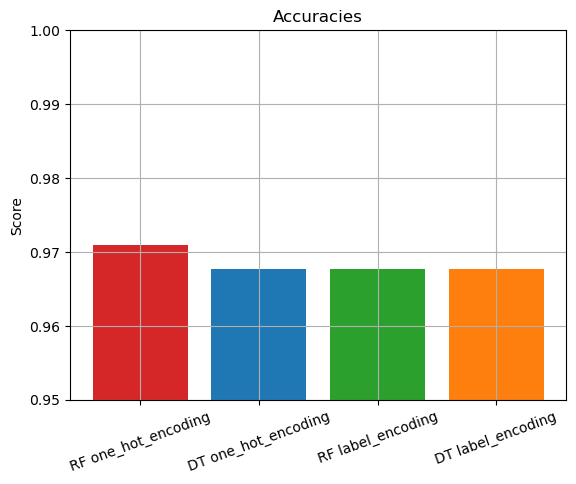

In [21]:
names = ['RF one_hot_encoding',
         'DT one_hot_encoding',
         'RF label_encoding',
         'DT label_encoding']
accuracies = [rf_best_accuracy,
              dt_best_accuracy,
              rf2_best_accuracy,
              dt2_best_accuracy]
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']


fig, ax = plt.subplots()
ax.bar(names, accuracies, color = bar_colors)
ax.set_ylabel('َScore')
ax.set_title('Accuracies')
ax.tick_params('x', rotation = 20)
ax.set_ylim(0.95,1)

ax.grid()

## 3- Creating model to predict stage without T, N, M

### Now we want to find another way to predict the stage of the tumors with other risk factors

- 1- Random Forrest Regressor --> Used for numerical data
- 2- Random Forrest Classifier ---> Used for categorical data

In [22]:
###get the number of unique values of each column
unique_value_counts = {}
for header in list(data.columns):
    unique_value_counts[header] = data[header].nunique()
unique_value_counts

{'Age': 535,
 'Sex': 2,
 'ECOG_PS': 8,
 'Smoking_PY': 99,
 'Smoking_Status': 4,
 'Ds_Site': 16,
 'T': 16,
 'N': 10,
 'M': 3,
 'Stage': 13,
 'Path': 34,
 'Status': 2}

### 3-1 choosing a subset of data
let's extract our needed Data <br>
- Drop columns `[T, M, N, Status]`
- Elicite Stage as y_train

In [23]:
df = data.drop(columns=['T','N','M','Status'])
X = df.drop(columns=['Stage'])
y = df[['Stage']]    # Pay attention some values are 0 (int); turn them to str(0)

# turning int(0) to str(0)
y.loc[y.Stage == 0] = str(0)

C:\Users\ToTo\AppData\Local\Temp\ipykernel_7340\1418341645.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y.Stage == 0] = str(0)


### 3-2- Label encoding from scratch
First we write a general function for putting number instead of each value in the order

Lately we will use python libraries to automate this

In [24]:
def category_to_num(df:pd.DataFrame, column):
    """
    Inputs: a dataframe and the column we would change
    outputs: dictionary of {val:number} and changed df
    """

    unique_values = sorted(df[column].unique())
    # Initialize the dictionary
    unique_values_dict = {}
    # print(unique_values)
    for i in range(len(unique_values)):
        unique_values_dict[unique_values[i]] = i
    
    for i in range(len(df[column])):
        df = df.replace(unique_values_dict)

    return unique_values_dict, df

Changing columns of `[Sex, ECOG_PS, Smoking_Status, Ds_Site, Path]`

In [25]:
X

,Age,Sex,ECOG_PS,Smoking_PY,Smoking_Status,Ds_Site,Path
0,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,Squamous Cell Carcinoma
1,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Squamous Cell Carcinoma
2,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Squamous Cell Carcinoma
3,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Squamous Cell Carcinoma
4,72.3,Male,ECOG 0,55,Current,Larynx,Squamous Cell Carcinoma
...,...,...,...,...,...,...,...
3086,58.3,Male,ECOG 0,50,Ex-smoker,Oropharynx,Squamous Cell Carcinoma
3087,52.4,Female,ECOG 0,30,Current,Oropharynx,Squamous Cell Carcinoma
3088,71.3,Male,ECOG 1,50,Ex-smoker,Oropharynx,Squamous Cell Carcinoma
3089,53.9,Female,ECOG 0,5,Current,Oropharynx,Squamous Cell Carcinoma


May takes more than one minute

In [26]:
categories = ['Sex', 'ECOG_PS', 'Smoking_Status', 'Ds_Site', 'Path']

# change categorical values of X to numbers with function implemented above
X_column_dictionaries = []    # Saving cache of dictionaries
le_X = X.copy(deep =True)
le_y = y.copy(deep =True)

for header in categories:
    X_values_dict, le_X = category_to_num(le_X, header)
    X_column_dictionaries.append(X_values_dict)

# change categorical values of y to numbers
y_column_dictionary, le_y = category_to_num(le_y, 'Stage')

In [27]:
le_X

,Age,Sex,ECOG_PS,Smoking_PY,Smoking_Status,Ds_Site,Path
0,62.6,0,0,50,1,8,27
1,87.3,1,3,25,1,3,27
2,49.9,1,2,15,1,8,27
3,59.7,0,0,0,2,8,27
4,72.3,1,0,55,0,3,27
...,...,...,...,...,...,...,...
3086,58.3,1,0,50,1,8,27
3087,52.4,0,0,30,0,8,27
3088,71.3,1,2,50,1,8,27
3089,53.9,0,0,5,0,8,27


With a brief look at values of columns, We recognize that `X.Smoking_PY.unique()` contains some  <br>
values like `">50", "<5"` don't need strings in our numerical values <br>
- remove > and < and if it will not be negative, add and subtract 4.99 to it (approximation)


In [28]:
#le_X.Smoking_PY.unique()    # there is not angle bracket beside a number less than 5
for i in range(len(le_X.Smoking_PY)):

    if type(le_X.Smoking_PY[i]) == str:

        if le_X.Smoking_PY[i][0] == '<':
            le_X.replace(le_X.Smoking_PY.loc[i] , int(le_X.Smoking_PY[i][1:]) - 4.99, inplace=True)
            
        elif le_X.Smoking_PY[i][0] == '>':
            le_X.replace(le_X.Smoking_PY.loc[i] , int(le_X.Smoking_PY[i][1:]) + 4.99, inplace=True)
le_X.Smoking_PY.astype('float')

print(le_X.Smoking_PY.unique())

[5.000e+01 2.500e+01 1.500e+01 0.000e+00 5.500e+01 5.000e+00 2.000e+01
 4.000e+01 2.200e+01 3.000e+01 3.500e+01 1.000e+01 6.000e+01 2.000e+00
 1.000e+02 4.900e+01 6.750e+01 6.500e+01 4.500e+01 9.000e+01 8.000e+01
 7.000e+00 1.700e+01 5.200e+01 4.300e+01 1.600e+01 8.000e+00 4.000e+00
 3.000e+00 7.500e+00 3.700e+01 1.800e+01 2.100e+01 3.200e+01 3.400e+01
 2.499e+01 4.700e+01 7.000e+01 1.900e+01 1.400e+01 3.300e+01 7.500e+01
 5.000e-01 6.000e+00 1.750e+01 3.000e-01 2.400e+02 2.750e+01 7.800e+01
 5.499e+01 2.300e+01 1.250e+01 4.200e+01 3.600e+01 1.500e+02 1.200e+01
 1.000e+00 1.501e+01 7.400e+01 3.800e+01 6.400e+01 2.500e+00 5.300e+01
 5.010e+00 1.100e+01 2.400e+01 4.400e+01 2.999e+01 1.200e+02 1.100e+02
 6.700e+01 6.200e+01 2.600e+01 9.000e+00 1.300e+01 1.350e+01 3.900e+01
 1.150e+02 2.700e+01 2.800e+01 4.600e+01 1.350e+02 2.250e+01 1.500e+00
 5.700e+01 1.000e-02 8.600e+01 3.100e+01 8.500e+00 4.800e+01 1.180e+02
 1.050e+02 1.080e+02 6.600e+01 5.400e+01 3.750e+01 4.100e+01 5.600e+01
 2.030

### 3-3 Random Forest Classifier
#### PAY ATTENTION
Accuracy score functions give 1-d array and a series values should be raveled before entering the accuracy testing functions<br>
Accuracy score functions give a 1-d array with `dtype = int64` or sth other in  this family<br>
Do NOT enter an array with `dtype=object` in it otherwise you will face:<br> `Classification metrics can't handle a mix of unknown and multiclass targets`

In [29]:
# Split data into train, testa
X_train, Xs, y_train, ys = train_test_split(le_X,le_y, test_size=0.4)
X_test, X_validation, y_test, y_validation = train_test_split(Xs,ys, test_size=0.5)
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
X_train

,Age,Sex,ECOG_PS,Smoking_PY,Smoking_Status,Ds_Site,Path
793,36.2,0,0,0.0,2,6,13
3063,40.9,0,0,0.0,2,8,27
1967,78.2,1,2,50.0,1,3,27
2527,63.4,1,2,47.0,0,8,27
1322,84.0,0,2,40.0,1,3,27
...,...,...,...,...,...,...,...
1062,57.4,0,2,0.0,2,8,27
1619,61.3,1,0,30.0,1,3,28
926,77.4,1,2,45.0,0,3,27
2398,81.8,1,2,20.0,1,8,27


In [31]:
RandomForestClassifier().get_params()
params = {'bootstrap': [True],
 'max_depth': [7, 10, 30, None],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [50, 100, 200]}

hp_values = list(params.values())    # hp stands for hyper parameters

# Initialize best_param & accuracy
rfcle_best_param = None
rfcle_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = RandomForestClassifier( bootstrap = hp[0],
                                       max_depth = hp[1],
                                       min_samples_leaf = hp[2],
                                       min_samples_split = hp[3],
                                       n_estimators = hp[4],
                                       random_state= 42
                                       )
    # Fit the model
    estimator.fit(X_train, y_train.values.ravel())

    # We should enter 2 `1-d array, dtype=int64` in our accuracy scoring funtion
    accuracy = estimator.score(X_validation, y_validation.values.ravel())
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > rfcle_best_accuracy:
        rfcle_best_accuracy = estimator.score(X_test, y_test)
        rfcle_best_param = hp

Parameters used: (True, 7, 1, 2, 50)
Mean accuracy of the model: 0.5492730210016155



Parameters used: (True, 7, 1, 2, 100)
Mean accuracy of the model: 0.555735056542811

Parameters used: (True, 7, 1, 2, 200)
Mean accuracy of the model: 0.5573505654281099

Parameters used: (True, 7, 1, 5, 50)
Mean accuracy of the model: 0.5589660743134087

Parameters used: (True, 7, 1, 5, 100)
Mean accuracy of the model: 0.5654281098546042

Parameters used: (True, 7, 1, 5, 200)
Mean accuracy of the model: 0.5589660743134087

Parameters used: (True, 7, 2, 2, 50)
Mean accuracy of the model: 0.5573505654281099

Parameters used: (True, 7, 2, 2, 100)
Mean accuracy of the model: 0.5541195476575121

Parameters used: (True, 7, 2, 2, 200)
Mean accuracy of the model: 0.5492730210016155

Parameters used: (True, 7, 2, 5, 50)
Mean accuracy of the model: 0.5508885298869144

Parameters used: (True, 7, 2, 5, 100)
Mean accuracy of the model: 0.5573505654281099

Parameters used: (True, 7, 2, 5, 200)
Mean accuracy of the model: 0.555735056542811

Parameters used: (True, 10, 1, 2, 50)
Mean accuracy of the 

In [32]:
# RandomForestClassifier().get_params()
# params = {'bootstrap': [True],
#  'max_depth': [7, 10, 30, None],
#  'min_samples_leaf': [1, 2],
#  'min_samples_split': [2, 5],
#  'n_estimators': [50, 100, 200]}

# hp_values = list(params.values())    # hp stands for hyper parameters

# # Initialize best_param & accuracy
# rfcle_best_param = None
# rfcle_best_accuracy = 0

# # Loop through the combinations of hyperparams
# for hp in itertools.product(*hp_values):

#     # Create the model with the hyperparams
#     estimator = RandomForestClassifier( bootstrap = hp[0],
#                                        max_depth = hp[1],
#                                        min_samples_leaf = hp[2],
#                                        min_samples_split = hp[3],
#                                        n_estimators = hp[4],
#                                        random_state= 42
#                                        )
#     # Fit the model
#     estimator.fit(X_train, y_train.astype('int64').values.ravel())

#     # We should enter 2 `1-d array, dtype=int64` in our accuracy scoring funtion
#     accuracy = estimator.score(X_validation.astype('int64'), y_validation.astype('int64').values.ravel())
#     print(f"Parameters used: {hp}")
#     print(f"Mean accuracy of the model: {accuracy}\n")
    
#     if accuracy > rfcle_best_accuracy:
#         rfcle_best_accuracy = estimator.score(X_test, y_test)
#         rfcle_best_param = hp

In [33]:
print(f'Random Forest best accuracy is {rfcle_best_accuracy}, and best params aree {rfcle_best_param}\n')

Random Forest best accuracy is 0.5080906148867314, and best params aree (True, None, 2, 5, 200)



### 3-4 Random Forest with one_hot_encoding

In [34]:
he_X = pd.get_dummies(X[['Sex', 'ECOG_PS', 'Smoking_Status', 'Ds_Site', 'Path']], dtype=int)
he_y = pd.get_dummies(y, dtype=int) 

X_train, Xs, y_train, ys = train_test_split(he_X,he_y, test_size=0.4)
X_test, X_validation, y_test, y_validation = train_test_split(Xs,ys, test_size=0.5)

Implementing Model

In [35]:
RandomForestClassifier().get_params()
params = {'bootstrap': [True],
 'max_depth': [7, 10, 30, None],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [50, 100, 200]}

hp_values = list(params.values())    # hp stands for hyper parameters

# Initialize best_param & accuracy
rfche_best_param = None
rfche_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = RandomForestClassifier( bootstrap = hp[0],
                                       max_depth = hp[1],
                                       min_samples_leaf = hp[2],
                                       min_samples_split = hp[3],
                                       n_estimators = hp[4],
                                       random_state= 42
                                       )
    # Fit the model
    estimator.fit(X_train, y_train)

    # We should enter 2 `1-d array, dtype=int64` in our accuracy scoring funtion
    accuracy = estimator.score(X_validation, y_validation)
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > rfche_best_accuracy:
        rfche_best_accuracy = estimator.score(X_test, y_test)
        rfche_best_param = hp

Parameters used: (True, 7, 1, 2, 50)
Mean accuracy of the model: 0.3667205169628433

Parameters used: (True, 7, 1, 2, 100)
Mean accuracy of the model: 0.3651050080775444

Parameters used: (True, 7, 1, 2, 200)
Mean accuracy of the model: 0.37479806138933763

Parameters used: (True, 7, 1, 5, 50)
Mean accuracy of the model: 0.3651050080775444

Parameters used: (True, 7, 1, 5, 100)
Mean accuracy of the model: 0.3667205169628433

Parameters used: (True, 7, 1, 5, 200)
Mean accuracy of the model: 0.3683360258481422

Parameters used: (True, 7, 2, 2, 50)
Mean accuracy of the model: 0.36348949919224555

Parameters used: (True, 7, 2, 2, 100)
Mean accuracy of the model: 0.36187399030694667

Parameters used: (True, 7, 2, 2, 200)
Mean accuracy of the model: 0.3602584814216478

Parameters used: (True, 7, 2, 5, 50)
Mean accuracy of the model: 0.3570274636510501

Parameters used: (True, 7, 2, 5, 100)
Mean accuracy of the model: 0.36187399030694667

Parameters used: (True, 7, 2, 5, 200)
Mean accuracy of

In [36]:
print(f'Random Forest with one_hot_encoded best accuracy is {rfche_best_accuracy}, and best params aree {rfche_best_param}\n')

Random Forest with one_hot_encoded best accuracy is 0.40614886731391586, and best params aree (True, 7, 1, 2, 50)



### 4- How about categorizing age and smoking_PY?

### 4-1 Again making our X and y

In [37]:
df = data.drop(columns=['T','N','M','Status'])
X = df.drop(columns=['Stage'])
y = df[['Stage']]    # Pay attention some values are 0 (int); turn them to str(0)

# turning int(0) to str(0)
y.loc[y.Stage == 0] = str(0)

C:\Users\ToTo\AppData\Local\Temp\ipykernel_7340\1418341645.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y.Stage == 0] = str(0)


#### 4-2 Based on some articles we categorize the Age by 5 years
- Rawla P. Epidemiology of Prostate Cancer. World J Oncol. 2019 Apr;10(2):63-89. doi: 10.14740/wjon1191. Epub 2019 Apr 20. PMID: 31068988; PMCID: PMC6497009. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6497009/
- https://www.cancer.gov/about-cancer/causes-prevention/risk/age
- https://doi.org/10.3322/caac.21577

In [38]:
age_min_bin = int(5 * data.Age.min()//5)
age_max_bin = int(5 * (data.Age.max()//5 + 1))
age_bin_values = list(range(age_min_bin, age_max_bin, 5))

age_bins = pd.cut(data.Age, age_bin_values)    # It's a series that map each age to it's interval

# We can use this line to change the age with interval
# data.Age = bins

# Let's check the count of each interval
age_interval_count = data.groupby(age_bins).Age.agg(['count'])

age_interval_count

,count
Age,
"(15, 20]",3
"(20, 25]",7
"(25, 30]",8
"(30, 35]",22
"(35, 40]",39
"(40, 45]",108
"(45, 50]",241
"(50, 55]",378
"(55, 60]",491


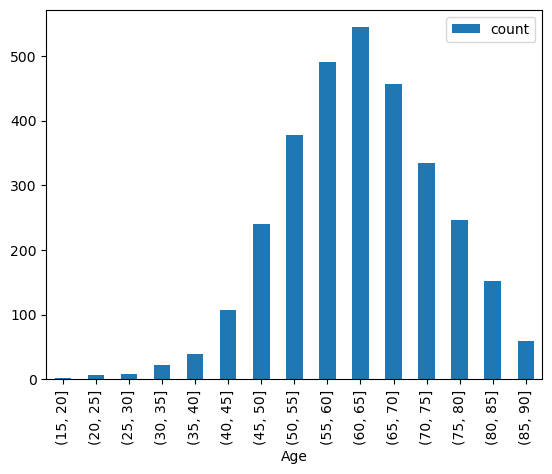

In [39]:
age_interval_count.plot(kind = 'bar')
plt.show()

### 4-3 We have about 100 different pocket per yer values
some values are <50 or >25
- 1- remove > and < and if it will not be negative, add and subtract 4.99 to it (approximation)
- 2- categorize them in groups ([0, 2.5], [2.5, 7.5], ... ) 0 is excluded

Now try to group them

In [40]:
# Done Before
for i in range(len(X.Smoking_PY)):

    if type(X.Smoking_PY[i]) == str:

        if X.Smoking_PY[i][0] == '<':
            X.Smoking_PY.replace(X.Smoking_PY.loc[i], int(X.Smoking_PY[i][1:]) - 4.99, inplace = True)
            
        elif X.Smoking_PY[i][0] == '>':
            X.Smoking_PY.replace(X.Smoking_PY.loc[i], int(X.Smoking_PY[i][1:]) + 4.99, inplace = True)

print(X.Smoking_PY.unique())

[5.000e+01 2.500e+01 1.500e+01 0.000e+00 5.500e+01 5.000e+00 2.000e+01
 4.000e+01 2.200e+01 3.000e+01 3.500e+01 1.000e+01 6.000e+01 2.000e+00
 1.000e+02 4.900e+01 6.750e+01 6.500e+01 4.500e+01 9.000e+01 8.000e+01
 7.000e+00 1.700e+01 5.200e+01 4.300e+01 1.600e+01 8.000e+00 4.000e+00
 3.000e+00 7.500e+00 3.700e+01 1.800e+01 2.100e+01 3.200e+01 3.400e+01
 2.499e+01 4.700e+01 7.000e+01 1.900e+01 1.400e+01 3.300e+01 7.500e+01
 5.000e-01 6.000e+00 1.750e+01 3.000e-01 2.400e+02 2.750e+01 7.800e+01
 5.499e+01 2.300e+01 1.250e+01 4.200e+01 3.600e+01 1.500e+02 1.200e+01
 1.000e+00 1.501e+01 7.400e+01 3.800e+01 6.400e+01 2.500e+00 5.300e+01
 5.010e+00 1.100e+01 2.400e+01 4.400e+01 2.999e+01 1.200e+02 1.100e+02
 6.700e+01 6.200e+01 2.600e+01 9.000e+00 1.300e+01 1.350e+01 3.900e+01
 1.150e+02 2.700e+01 2.800e+01 4.600e+01 1.350e+02 2.250e+01 1.500e+00
 5.700e+01 1.000e-02 8.600e+01 3.100e+01 8.500e+00 4.800e+01 1.180e+02
 1.050e+02 1.080e+02 6.600e+01 5.400e+01 3.750e+01 4.100e+01 5.600e+01
 2.030

In [41]:
PY_min_bin = 0   # add 2.5 and want this for making range 
PY_max_bin = int(5 * (max(X.Smoking_PY.unique())//5 +1))    #add 2.5 to this later
PY_bin_values = list(range(PY_min_bin, PY_max_bin, 5))

# adding 2.5 to each entity and inserting small values at first for containing 0
PY_bin_values = [-0.001, 0.001] + [i+2.5 for i in PY_bin_values]

PY_bins = pd.cut(X.Smoking_PY, PY_bin_values, labels=False) #`labels` puts the order of bean as value [47.5,52.5] -> 11

# you can see the count of each bean
# Smoke_interval_count = X.groupby(bins).Smoking_PY.agg(['count'])
# Smoke_interval_count

# Replacing the Smoking_PY with mean of beans
for i in range(len(PY_bins)):
    if PY_bins[i] == 0:    #[-0.001, 0.001]
        X.Smoking_PY.replace(X.Smoking_PY.loc[i], 0, inplace=True)
    elif PY_bins[i] == 1:    #[0.001, 2.5]
        X.Smoking_PY.replace(X.Smoking_PY.loc[i], 1.5, inplace = True)
    else:
        X.Smoking_PY.replace(X.Smoking_PY.loc[i], (PY_bins[i] - 1) * 5, inplace = True)

X.Smoking_PY


0       50.0
1       25.0
2       15.0
3        0.0
4       55.0
        ... 
3086    50.0
3087    30.0
3088    50.0
3089     5.0
3090    15.0
Name: Smoking_PY, Length: 3091, dtype: float64

### 4-4 Renew the Age column

let's see unique values of each columns<br>
You can recognize that Age still has 535 values and as you know if we want to classify with respect to<br>
numerical values, we should use RandomForestRegressor and since most of our values are categorical we'll<br>
change the age column in a same way like Smoking_PY

In [42]:
unique_value_counts = {}
for header in list(X.columns):
    unique_value_counts[header] = X[header].nunique()
print(unique_value_counts)

# Changing the age column of X to the mean of interval
new_ages = list(((age_bins[i].left + age_bins[i].right)/2) for i in range(len(X)))
X.Age = new_ages

print('now: ',unique_value_counts)

X.head()

{'Age': 535, 'Sex': 2, 'ECOG_PS': 8, 'Smoking_PY': 28, 'Smoking_Status': 4, 'Ds_Site': 16, 'Path': 34}
now:  {'Age': 535, 'Sex': 2, 'ECOG_PS': 8, 'Smoking_PY': 28, 'Smoking_Status': 4, 'Ds_Site': 16, 'Path': 34}


,Age,Sex,ECOG_PS,Smoking_PY,Smoking_Status,Ds_Site,Path
0,62.5,Female,ECOG 0,50.0,Ex-smoker,Oropharynx,Squamous Cell Carcinoma
1,87.5,Male,ECOG 2,25.0,Ex-smoker,Larynx,Squamous Cell Carcinoma
2,47.5,Male,ECOG 1,15.0,Ex-smoker,Oropharynx,Squamous Cell Carcinoma
3,57.5,Female,ECOG 0,0.0,Non-smoker,Oropharynx,Squamous Cell Carcinoma
4,72.5,Male,ECOG 0,55.0,Current,Larynx,Squamous Cell Carcinoma


Now We want to do the same as before; Considering the Age and Smoking_PY have less values
### 4-4 Random Frorrest Classifier with label encoding
- 4-4-1 label encoding


In [43]:
le = LabelEncoder()

le_X = X.copy(deep=True)
le_y = y.copy(deep=True)

# These columns shoud be encoded['Sex', 'ECOG_PS', 'Smoking_Status', 'Ds_Site', 'Path']
le_X['Sex'] = le.fit_transform(X['Sex'])
le_X['ECOG_PS'] = le.fit_transform(X['ECOG_PS'])
le_X['Smoking_Status'] = le.fit_transform(X['Smoking_Status']) 
le_X['Ds_Site'] = le.fit_transform(X['Ds_Site']) 
le_X['Path'] = le.fit_transform(X['Path']) 

le_y['Stage'] = le.fit_transform(y['Stage'])

X_train, Xs, y_train, ys = train_test_split(le_X,le_y, test_size=0.4)
X_test, X_validation, y_test, y_validation = train_test_split(Xs,ys, test_size=0.5)

- 4-4-2 implementing algorithm

In [44]:
RandomForestClassifier().get_params()
params = {'bootstrap': [True],
 'max_depth': [7, 10, 30, None],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [50, 100, 200]}

hp_values = list(params.values())    # hp stands for hyper parameters

# Initialize best_param & accuracy
rfcle2_best_param = None
rfcle2_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = RandomForestClassifier( bootstrap = hp[0],
                                       max_depth = hp[1],
                                       min_samples_leaf = hp[2],
                                       min_samples_split = hp[3],
                                       n_estimators = hp[4],
                                       random_state= 42
                                       )
    # Fit the model
    estimator.fit(X_train, y_train.values.ravel())

    # We should enter 2 `1-d array, dtype=int64` in our accuracy scoring funtion
    accuracy = estimator.score(X_validation, y_validation.values.ravel())
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > rfcle2_best_accuracy:
        rfcle2_best_accuracy = estimator.score(X_test, y_test.values.ravel())
        rfcle2_best_param = hp

Parameters used: (True, 7, 1, 2, 50)
Mean accuracy of the model: 0.5492730210016155

Parameters used: (True, 7, 1, 2, 100)
Mean accuracy of the model: 0.5492730210016155

Parameters used: (True, 7, 1, 2, 200)
Mean accuracy of the model: 0.5525040387722132

Parameters used: (True, 7, 1, 5, 50)
Mean accuracy of the model: 0.5573505654281099

Parameters used: (True, 7, 1, 5, 100)
Mean accuracy of the model: 0.5492730210016155

Parameters used: (True, 7, 1, 5, 200)
Mean accuracy of the model: 0.5476575121163166

Parameters used: (True, 7, 2, 2, 50)
Mean accuracy of the model: 0.5541195476575121

Parameters used: (True, 7, 2, 2, 100)
Mean accuracy of the model: 0.5508885298869144

Parameters used: (True, 7, 2, 2, 200)
Mean accuracy of the model: 0.5525040387722132

Parameters used: (True, 7, 2, 5, 50)
Mean accuracy of the model: 0.5605815831987075

Parameters used: (True, 7, 2, 5, 100)
Mean accuracy of the model: 0.5508885298869144

Parameters used: (True, 7, 2, 5, 200)
Mean accuracy of the

In [45]:
print(f'Random Forest with label encoded best accuracy is {rfcle2_best_accuracy}, and best params aree {rfcle2_best_param}\n')

Random Forest with label encoded best accuracy is 0.5728155339805825, and best params aree (True, 7, 1, 2, 50)



### 4-5 Random Forest Classifier with one_hot_Endoding
- 4-5-1 one hot encode ['Sex', 'ECOG_PS', 'Smoking_Status', 'Ds_Site', 'Path']
- he --> hot_encoded

In [46]:
he_X = pd.get_dummies(X[['Sex', 'ECOG_PS', 'Smoking_Status', 'Ds_Site', 'Path']], dtype=int)
he_y = pd.get_dummies(y, dtype=int) 

X_train, Xs, y_train, ys = train_test_split(he_X,he_y, test_size=0.4)
X_test, X_validation, y_test, y_validation = train_test_split(Xs,ys, test_size=0.5)

- 4-5-2 Implement the Model

In [47]:
RandomForestClassifier().get_params()
params = {'bootstrap': [True],
 'max_depth': [7, 10, 30, None],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 5],
 'n_estimators': [50, 100, 200]}

hp_values = list(params.values())    # hp stands for hyper parameters

# Initialize best_param & accuracy
rfche2_best_param = None
rfche2_best_accuracy = 0

# Loop through the combinations of hyperparams
for hp in itertools.product(*hp_values):

    # Create the model with the hyperparams
    estimator = RandomForestClassifier( bootstrap = hp[0],
                                       max_depth = hp[1],
                                       min_samples_leaf = hp[2],
                                       min_samples_split = hp[3],
                                       n_estimators = hp[4],
                                       random_state= 42
                                       )
    # Fit the model
    estimator.fit(X_train, y_train)

    # We should enter 2 `1-d array, dtype=int64` in our accuracy scoring funtion
    accuracy = estimator.score(X_validation, y_validation)
    print(f"Parameters used: {hp}")
    print(f"Mean accuracy of the model: {accuracy}\n")
    
    if accuracy > rfche2_best_accuracy:
        rfche2_best_accuracy = estimator.score(X_test, y_test)
        rfche2_best_param = hp

Parameters used: (True, 7, 1, 2, 50)
Mean accuracy of the model: 0.41033925686591277

Parameters used: (True, 7, 1, 2, 100)
Mean accuracy of the model: 0.39418416801292405

Parameters used: (True, 7, 1, 2, 200)
Mean accuracy of the model: 0.3893376413570275

Parameters used: (True, 7, 1, 5, 50)
Mean accuracy of the model: 0.40549273021001614

Parameters used: (True, 7, 1, 5, 100)
Mean accuracy of the model: 0.40549273021001614

Parameters used: (True, 7, 1, 5, 200)
Mean accuracy of the model: 0.3893376413570275

Parameters used: (True, 7, 2, 2, 50)
Mean accuracy of the model: 0.3893376413570275

Parameters used: (True, 7, 2, 2, 100)
Mean accuracy of the model: 0.3893376413570275

Parameters used: (True, 7, 2, 2, 200)
Mean accuracy of the model: 0.3861066235864297

Parameters used: (True, 7, 2, 5, 50)
Mean accuracy of the model: 0.407108239095315

Parameters used: (True, 7, 2, 5, 100)
Mean accuracy of the model: 0.3861066235864297

Parameters used: (True, 7, 2, 5, 200)
Mean accuracy of 

In [48]:
print(f'Random Forest with one_hot_encoded best accuracy is {rfche2_best_accuracy}, and best params aree {rfche2_best_param}\n')

Random Forest with one_hot_encoded best accuracy is 0.3656957928802589, and best params aree (True, None, 2, 5, 200)



In [49]:
print(f'Random Forest with label encoded best accuracy is {rfcle_best_accuracy}')
print(f'Random Forest with one_hot_encoded best accuracy is {rfche_best_accuracy}')
print(f'Categorized Random Forest with label encoded best accuracy is {rfcle2_best_accuracy}')
print(f'Categorized Random Forest with one_hot_encoded best accuracy is {rfche2_best_accuracy}')

Random Forest with label encoded best accuracy is 0.5080906148867314
Random Forest with one_hot_encoded best accuracy is 0.40614886731391586
Categorized Random Forest with label encoded best accuracy is 0.5728155339805825
Categorized Random Forest with one_hot_encoded best accuracy is 0.3656957928802589


## 4-6- Deep learning_model
We'll use label encoding here

In [50]:
# le_X = pd.read_csv('le_X.csv', header=0)
# le_y = pd.read_csv('le_y.csv', header=0)
# le_X.drop(columns=['Unnamed: 0'], inplace = True)
# le_y.drop(columns=['Unnamed: 0'], inplace = True)

In [51]:
# Reminding
le_X

,Age,Sex,ECOG_PS,Smoking_PY,Smoking_Status,Ds_Site,Path
0,62.5,0,0,50.0,1,8,27
1,87.5,1,3,25.0,1,3,27
2,47.5,1,2,15.0,1,8,27
3,57.5,0,0,0.0,2,8,27
4,72.5,1,0,55.0,0,3,27
...,...,...,...,...,...,...,...
3086,57.5,1,0,50.0,1,8,27
3087,52.5,0,0,30.0,0,8,27
3088,72.5,1,2,50.0,1,8,27
3089,52.5,0,0,5.0,0,8,27


In [52]:
# Standardizing the datas by `StandardScaler`
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(le_X.values,le_y.values, test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
y_train_encoded = to_categorical(y_train, num_classes=14)
y_test_encoded = to_categorical(y_test, num_classes=14)

In [54]:
#Creating model
model = models.Sequential()
model.add(Dense(units = 128, activation = 'relu', input_shape = (X_train.shape[1],)))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units = 14, activation = 'softmax'))

# Compiling model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Fitting model
history = model.fit(x=X_train, y=y_train_encoded,
                    epochs = 50,
                    batch_size=32,
                    validation_split=0.2,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 14)                910       
                                                                 
Total params: 10190 (39.80 KB)
Trainable params: 10190 (39.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


62/62 [==============================] - 1s 4ms/step - loss: 2.1163 - accuracy: 0.3465 - val_loss: 1.5347 - val_accuracy: 0.4626
Epoch 2/50
62/62 [==============================] - 0s 1ms/step - loss: 1.4936 - accuracy: 0.4679 - val_loss: 1.4091 - val_accuracy: 0.4667
Epoch 3/50
62/62 [==============================] - 0s 1ms/step - loss: 1.4224 - accuracy: 0.4992 - val_loss: 1.3886 - val_accuracy: 0.4788
Epoch 4/50
62/62 [==============================] - 0s 1ms/step - loss: 1.3828 - accuracy: 0.5003 - val_loss: 1.3819 - val_accuracy: 0.4788
Epoch 5/50
62/62 [==============================] - 0s 1ms/step - loss: 1.3684 - accuracy: 0.5149 - val_loss: 1.3801 - val_accuracy: 0.4808
Epoch 6/50
62/62 [==============================] - 0s 1ms/step - loss: 1.3555 - accuracy: 0.5114 - val_loss: 1.3715 - val_accuracy: 0.4828
Epoch 7/50
62/62 [==============================] - 0s 1ms/step - loss: 1.3470 - accuracy: 0.5139 - val_loss: 1.3659 - val_accuracy: 0.4808
Epoch 8/50
62/62 [=============

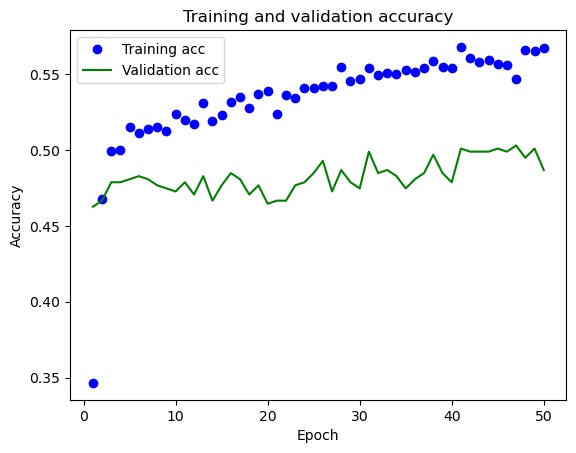

In [55]:
# Plotting to find where we face with overfitting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [56]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test accuracy: {test_accuracy}")

20/20 [==============================] - 0s 839us/step - loss: 1.2973 - accuracy: 0.5218


Test accuracy: 0.5218093991279602


## 5 - Conclusion

let me show U the final accuracies

In [57]:

print(f'Random Forest with label encoded best accuracy is {rfcle_best_accuracy}')
print(f'Random Forest with one_hot_encoded best accuracy is {rfche_best_accuracy}')
print(f'Categorized Random Forest with label encoded best accuracy is {rfcle2_best_accuracy}')
print(f'Categorized Random Forest with one_hot_encoded best accuracy is {rfche2_best_accuracy}')

Random Forest with label encoded best accuracy is 0.5080906148867314
Random Forest with one_hot_encoded best accuracy is 0.40614886731391586
Categorized Random Forest with label encoded best accuracy is 0.5728155339805825
Categorized Random Forest with one_hot_encoded best accuracy is 0.3656957928802589


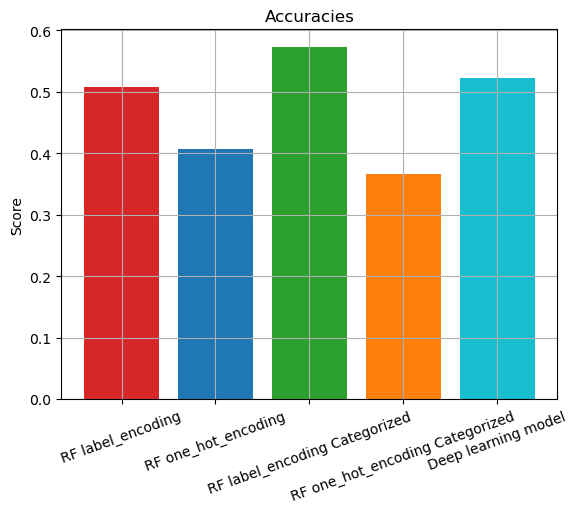

In [60]:
names = ['RF label_encoding',
         'RF one_hot_encoding',
         'RF label_encoding Categorized',
         'RF one_hot_encoding Categorized',
         'Deep learning model']
accuracies = [rfcle_best_accuracy,
              rfche_best_accuracy,
              rfcle2_best_accuracy,
              rfche2_best_accuracy,
              test_accuracy]
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:cyan']


fig, ax = plt.subplots()
ax.bar(names, accuracies, color = bar_colors)
ax.set_ylabel('َScore')
ax.set_title('Accuracies')
ax.tick_params('x', rotation = 20)

ax.grid()

### None of this models can predict the stage of cancer significantly True